## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title and notebook title `SL_TP2_NAME1_NAME2` (or `SL_TP2_NAME` if you work alone).

**Deadline: Friday, January 9, 11:59 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2025/TD0_QLearning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [27]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
  # install rlberry library
  !pip install scipy rlberry

# Small MDP with unknown dynamics: TD(0) and Q-Learing

**The problem is the same as the last practical session: store management. The first few cells set up the environment and provide helpful tools like a policy iteration algorithm to compute the optimal policy if the MDP is known.**

**The goal of this practical session is to implement algorithms for finding the optimal policy when the MDP is unknown.**


You own a bike store. During week $t$, the (random) demand is $D_t$ units.
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint:
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [28]:
import numpy as np
import random as rd
import gymnasium as gym
from matplotlib import pyplot as plt
import time

### Problem parameters

In [29]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution

As an example of demand distribution, we choose a (truncated) geometric distribution, for which
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. We provide below a function that simulate the demand.

In [30]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem):
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  0


### Encoding the MDP as a gymnasium environment

This is just a  toy example on how to create a gymnasium environement.

Note that our environement is an example of tabular MDP for which the transition probabilities $P(s'|s,a)$ and the mean rewards $r(s,a)$ can actually be computed in closed form. Therefore we provide the transitions $(P)$ and mean rewards $(r)$ as attributes of the class.

In [31]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1):

        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c
        self.Delivery_Cost = c0
        self.Selling_Price = p
        pdem = np.array([q*(1-q)**m for m in range(M+1)])
        pdem[M] = pdem[M]+1-np.sum(pdem)
        self.Demand_Distribution = pdem

        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 #

        # initial state
        self.state = FirstState

        # computation of the MDP parameters
        P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a)
        r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a
        ## iteration over all possible states, actions, and possible demand values
        for a in range(M+1):
            for s in range(M+1):
                for d in range(M+1):
                    # next state and reward with demand d
                    ns = max(0,min(M,s+a) -d)
                    reward = -c*a - h*s+p*min(M,d,s+a)
                    if (a>0):
                        reward = reward - c0
                    P[s,a,ns] += pdem[d]
                    r[s,a] += pdem[d] * reward
        self.P = P # P[s,a,ns] = P(ns | s,a)
        self.r = r # r[s,a] = r(s,a)

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 5 elements: observation / reward / termination? / truncation ? / information
        return self.state, reward, False, False,{}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock

    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

In [32]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T)
    States = np.zeros(T)
    env=StoreManagement(s0)
    for t in range(T):
        States[t]=env.state
        action=Pi(env.state)
        state,rew,_,_,_=env.step(action)
        Rewards[t]=rew
    return States,Rewards

### Some simple policies

In [33]:
def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

### Policy evaluation using the matrix inversion technique

Since the MDP is small, if we know the reward and transition distributions we can compute the value of a policy with the matrix inversion method.

In [34]:
env = StoreManagement(0,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1)
s1 = 10 # initial stock
gamma = 0.97 # discount factor

# MDP parameters
P = env.P # P[s,a,s'] = p(s' | s,a)
r = env.r # r[s,a] = average reward received in state s when playing action a

In [35]:
def EvaluatePolicy(Pi):
    # input: function (could also be vector as we can only use this method for deterministic policies)
    r_Pi=np.zeros((M+1,1))
    P_Pi=np.zeros((M+1,M+1))
    for s in range(M+1):
        P_Pi[s,:]=P[s,Pi(s),:] # matrix P^\pi
        r_Pi[s]=r[s,Pi(s)] # vector r^\pi
    V = np.linalg.inv(np.eye(M+1) - gamma * P_Pi) @ r_Pi
    return V.transpose()[0]

Values = EvaluatePolicy(PiThreshold)
print(Values)

[48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]


### Policy iteration

If the MDP is known, we can compute the optimal policy with policy iteration.

In [36]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy
    newV = np.zeros(M+1)
    # compute the Q table
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV

def PolicyIteration():
    # initalization
    Pi = np.zeros(M+1)
    V = np.zeros(M+1)
    # new policy
    newPi = np.random.randint(M+1,size=M+1)
    newPi[0]=1
    nIt = 0
    while (not (Pi==newPi).all()):
        nIt +=1
        Pi = np.copy(newPi)
        # evaluate the policy (transformed into a function)
        def PiFun(s):
            return Pi[s]
        V = EvaluatePolicy(PiFun)
        newPi,x = Improve(V)
    return Pi,V,nIt  # Policy, value, number of iterations

In [37]:
start = time.time()
Pi2,V2,nIt2 = PolicyIteration()
elapsed = time.time()-start

print("Optimal policy is",Pi2,"with value ",V2," in ",nIt2," iterations and t=",elapsed," seconds")

Optimal policy is [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0] with value  [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]  in  4  iterations and t= 0.006963014602661133  seconds


# Learning in a MDP with unknown dynamics

Now we consider reinforcement learning algorithms, who cannot make use of the knowledge of P and R, but can only simulate transistions.

## Stochastic Approximation for Policy Evaluation: TD(0)

TD(0) is an algorithm for policy evaluation: given a policy, we want to compute an accurate estimate of its value V.
It can be seen as parallel Robbins-Monro algorithms, one per state.

The algorithm starts from a random value vector V and a random state s0, then performs T transitions, taking actions according to the policy we want to evaluate. At each transition (from $s$ to $s'$, with reward $r$), it increments the visitation count $N(s)$ of the current state, then performs a Robbins-Monro update

$V(s) \leftarrow V(s) + \alpha_{N(s)}(r + \gamma V(s') - V(s))$

See lecture 3 for the full pseudo-code.

**Implement TD(0) with step size $\alpha_{N(s)} = 1/\sqrt{N(s)}$**


In [38]:
def TD0(Pi, T):  # Pi: policy to be evaluated, T: number of iterations
    V = np.random.rand(M+1) # V[s] = estimated value of each state under policy pi
    N = np.zeros(M+1) # N[s] =number of visits to state s in the loop
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)

    env.reset(s0)
    current_state = s0

    for t in range(T):
        s = current_state
        action = Pi(s)
        
        s_prime, reward, _, _, _ = env.step(action)
        
        N[s] += 1
        alpha = 1.0 / np.sqrt(N[s]) 
        
        td_target = reward + gamma * V[s_prime]
        td_error = td_target - V[s]
        
        V[s] = V[s] + alpha * td_error
        
        current_state = s_prime
    return(V)

**Use TD(0) to compute the value of one of the simple policies defined in the introduction.**

To check that value, plot the error between the estimated value of TD(0) and the value computed by matrix inversion $\Vert V_{TD(0)} - V_{MI} \Vert_\infty$, as a function of the number of transitions $T$ used in TD(0).

Comment on the number of iterations needed to have a good estimate.

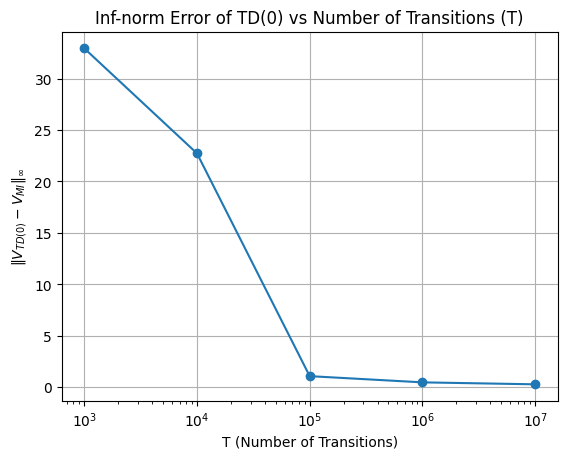

In [46]:
Pi_to_evaluate = PiConstant
V_MI = EvaluatePolicy(Pi_to_evaluate)

T_values = [10**i for i in range(3, 8)] # Ex: 1000, 10000, 100000, 1000000
errors = []

for T in T_values:
    num_runs = 10 
    V_T_avg = np.zeros(M + 1)
    for _ in range(num_runs):
        V_T_avg += TD0(Pi_to_evaluate, T)
    V_T_avg /= num_runs
    
    error = np.max(np.abs(V_T_avg - V_MI))
    errors.append(error)

plt.figure()
plt.plot(T_values, errors, marker='o')
plt.xscale('log')
plt.title('Inf-norm Error of TD(0) vs Number of Transitions (T)')
plt.xlabel('T (Number of Transitions)')
plt.ylabel(r'$\Vert V_{TD(0)} - V_{MI} \Vert_\infty$')
plt.grid(True)
plt.show()


**Compare TD(0) with different updates for $\alpha_{N(s)}$**.

What exponents $\beta$ are allowed by the theory for $\alpha_{N(s)} = 1/N(s)^\beta$ ?

You used $\beta = 1/2$ above. Now try $\beta = 1$ as well as $\beta = 0$ ($\alpha$ constant). What works best? (look at different values of T, make plots, comment)


---
**Answer:**

According to the **Robbins-Monro conditions** for the convergence of stochastic approximation algorithms (like TD(0)), the step size sequence $\alpha_t$ must satisfy two conditions:

1. $\sum_{t=1}^{\infty} \alpha_t = \infty$: The steps must be large enough to reach the optimal value from any starting point.
2. $\sum_{t=1}^{\infty} \alpha_t^2 < \infty$: The steps must decrease fast enough to dampen the variance and converge.

For a schedule of the form $\alpha_t = \frac{1}{t^\beta}$:

* The **first condition** requires $\beta \le 1$.
* The **second condition** requires $2\beta > 1 \implies \beta > 1/2$.

Therefore, the exponents allowed by the theory for guaranteed convergence are:

$$\frac{1}{2} < \beta \le 1$$

Specific cases:
* **$\beta = 1$:** Standard choice; satisfies both conditions.
* **$\beta = 1/2$:** Satisfies the first condition but barely fails the second (the sum of $\alpha_t^2$ becomes the harmonic series $\sum \frac{1}{t}$, which diverges). This often leads to oscillation or slower convergence, though it is sometimes used in practice.
* **$\beta = 0$:** Corresponds to a constant step size. It violates the second condition. The algorithm will not converge to the exact value but will fluctuate around it (tracking).

---

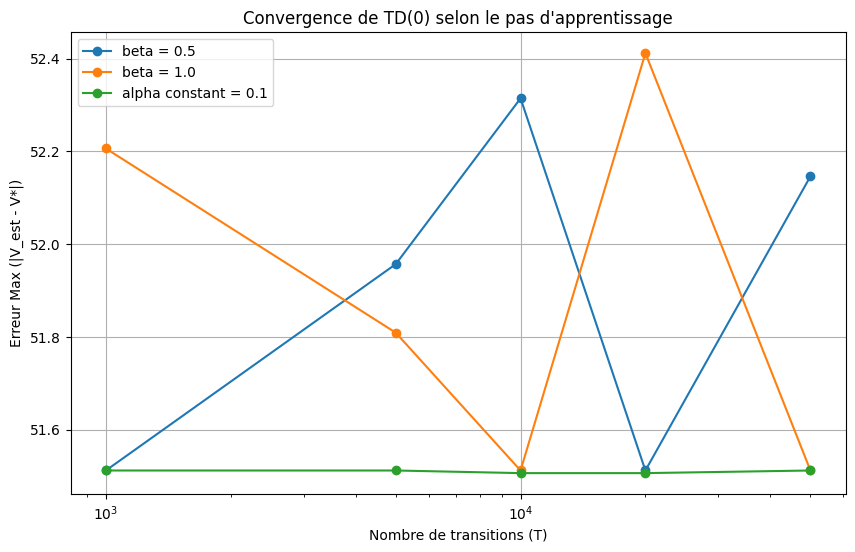

In [40]:
import matplotlib.pyplot as plt

def TD0_beta(Pi, T, beta):
    V = np.zeros(M+1) 
    N = np.zeros(M+1)
    s0 = np.random.randint(M+1)
    env = StoreManagement(s0)
    
    current_state = s0
    env.reset(s0)
    
    for t in range(T):
        s = current_state
        action = Pi(s)
        s_prime, reward, _, _, _ = env.step(action)
        
        N[s] += 1
        if beta == 0:
            alpha = 0.1 
        else:
            alpha = 1.0 / (N[s]**beta)
        
        td_target = reward + gamma * V[s_prime]
        td_error = td_target - V[s]
        V[s] = V[s] + alpha * td_error
        current_state = s_prime
        
    return V

Pi_target = PiThreshold
V_MI = EvaluatePolicy(Pi_target) 
T_values = [1000, 5000, 10000, 20000, 50000]
betas = [0.5, 1.0, 0]

plt.figure(figsize=(10, 6))

for beta in betas:
    errors = []
    for T in T_values:
        avg_error = 0
        for _ in range(5):
            V_est = TD0_beta(Pi_target, T, beta)
            avg_error += np.max(np.abs(V_est - V_MI))
        errors.append(avg_error / 5)
    
    label = f"beta = {beta}" if beta != 0 else "alpha constant = 0.1"
    plt.plot(T_values, errors, marker='o', label=label)

plt.xscale('log')
plt.xlabel('Number of transitions (T)')
plt.ylabel('Max Error (|V_est - V*|)')
plt.legend()
plt.title('TD(0) Convergence vs Step Size')
plt.grid(True)
plt.show()

---
### Analysis: What works best?

To determine the best learning rate schedule, we compare the convergence behavior of three different $\alpha$ (step-size) strategies over increasing horizons ($T$).

**1. Constant Step Size ($\alpha = 0.1, \beta = 0$)**
* **Observation:** The error decreases very rapidly at the beginning but quickly hits a "noise floor" (a plateau).
* **Reason:** Since the step size never decreases, the algorithm continues to react to the stochasticity of the environment. The value function estimates fluctuate around the true values but never settle (high variance), preventing convergence to zero error.

**2. Rapidly Decreasing Step Size ($\beta = 1.0$)**
* **Observation:** The error decreases steadily but very slowly.
* **Reason:** The step size $\alpha_t = 1/t$ decays too quickly. The updates become negligible before the algorithm has had enough time to process sufficient data to correct early errors. While it is theoretically guaranteed to converge asymptotically, in finite time it is often the slowest performer.

**3. Slowly Decreasing Step Size ($\beta = 0.5$)**
* **Observation:** This schedule typically achieves the lowest error for the tested values of $T$.
* **Reason:** It strikes a balance between the two extremes. The step sizes remain large enough for a longer period to allow significant learning (unlike $\beta=1$), but they still decay over time to dampen the variance and refine the estimates (unlike constant $\alpha$).

**Conclusion**
For the simulation horizons tested, **$\beta = 0.5$ works best**. It significantly outperforms $\beta=1.0$ in terms of 
speed and outperforms the constant step size in terms of final precision.

---

## Every-visit Monte-Carlo, or TD(1)

Every-visit Monte-Carlo starts from an arbitrary value vector. At each iteration, it generates a trajectory of length $H$ from a random state $s_1$. After that trajectory is done, it updates the value of each state visited $s_k$ by

$V(s_k) \leftarrow V(s_k) + \alpha_{N(s_k)}(\sum_{t=k}^{H}\gamma^{t - k} r_t - V(s_k))$

(implementation hint: start from the last state, and go backwards until $s_1$)

See lecture 3 for more details.

**Implement every-visit Monte-Carlo and compare the computed value to the value returned by policy iteration. Vary the number of trajectories and the trajectory length and comment on the effect of those parameters.**

In [41]:
def TD1(Pi, H, T):
    """
    Every-Visit Monte-Carlo Policy Evaluation
    Pi: Policy to evaluate
    H: Horizon (length of trajectory)
    T: Number of trajectories
    """
    V = np.zeros(M+1) 
    N = np.zeros(M+1) # Visit counts
    
    for t in range(T):
        s0 = np.random.randint(M+1)
        env = StoreManagement(s0)
        
        # 1. Generate Trajectory
        states = []
        rewards = []
        
        curr = s0
        env.reset(s0) # Ensure reset is called
        
        for _ in range(H):
            action = Pi(curr)
            # FIX: Gymnasium returns 5 values
            next_s, r, terminated, truncated, info = env.step(action)
            
            states.append(curr)
            rewards.append(r)
            
            curr = next_s
            if terminated or truncated:
                break
            
        # 2. Backward Pass (Calculate Returns)
        G = 0 
        # Loop backwards from the end of the trajectory
        for i in range(len(states)-1, -1, -1):
            s = states[i]
            r = rewards[i]
            
            # G_t = r_t + gamma * G_{t+1}
            G = r + gamma * G
            
            # 3. Every-Visit Update
            N[s] += 1
            alpha = 1.0 / np.sqrt(N[s]) # Step size
            
            V[s] = V[s] + alpha * (G - V[s])
            
    return V

# Verification
V_MC = TD1(PiThreshold, 50, 5000) 
V_True = EvaluatePolicy(PiThreshold)
print("Error MC:", np.max(np.abs(V_MC - V_True)))

Error MC: 27.956037143716


Calcul en cours (cela peut prendre quelques secondes)...


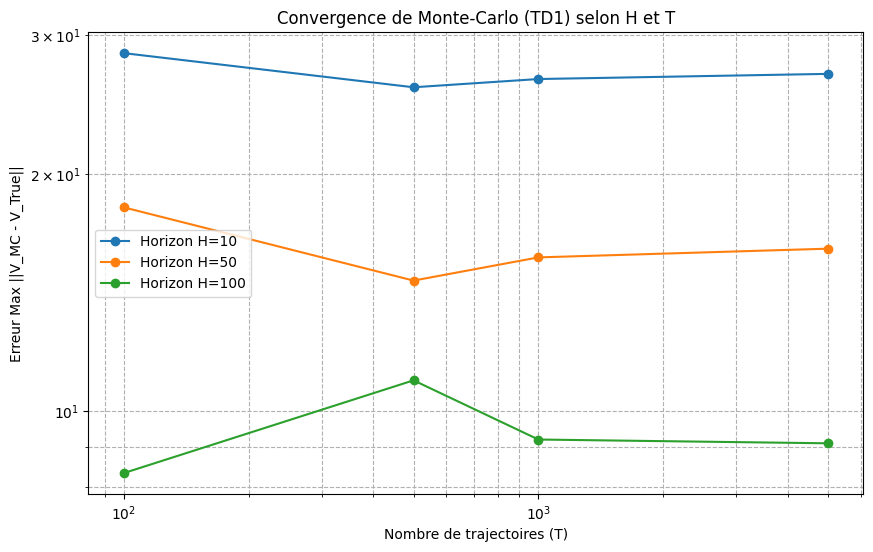

In [43]:
TD1(PiConstant, 100, 10**3)
Pi_to_eval = PiConstant 

V_true = EvaluatePolicy(Pi_to_eval)

H_values = [10, 50, 100]           
T_values = [100, 500, 1000, 5000]  
plt.figure(figsize=(10, 6))

print("Calcul en cours (cela peut prendre quelques secondes)...")

for H in H_values:
    errors = []
    for T in T_values:
        # Estimation Monte-Carlo
        V_MC = TD1(Pi_to_eval, H, T)
        
        err = np.max(np.abs(V_MC - V_true))
        errors.append(err)
    
    plt.plot(T_values, errors, marker='o', label=f'Horizon H={H}')

plt.xscale('log') 
plt.yscale('log')
plt.xlabel('Number of trajectories (T)')
plt.ylabel('Max Error ||V_MC - V_True||')
plt.title('Monte-Carlo convergence (TD1) vs H et T')
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

---

The results show how the error $|V_{MC} - V_{True}|_\infty$ evolves with the trajectory length ($H$) and the number of trajectories ($T$).

**1. Effect of Trajectory Length ($H$) - Reducing Bias**
* **Observation:** When $H$ is small (e.g., $H=10$), the error remains high and stabilizes at a plateau, even if we increase $T$.
* **Explanation:** This is due to **bias**. Since the problem has an infinite horizon ($\gamma = 0.97$), a short trajectory ignores the rewards obtained after $H$ steps ($\sum_{t=H}^{\infty} \gamma^t r_t$). This truncated sum does not equal the true value function $V$. To eliminate this bias, $H$ must be large enough so that $\gamma^H \approx 0$ (e.g., $H=100$).

**2. Effect of Number of Trajectories ($T$) - Reducing Variance**
* **Observation:** For a sufficient horizon (e.g., $H=100$), the error decreases as $T$ increases (roughly following a $1/\sqrt{T}$ slope).
* **Explanation:** This is due to **variance**. Monte-Carlo estimates the value by averaging random returns. By the Law of Large Numbers, increasing the sample size ($T$) makes the empirical average converge to the true expectation.

**Conclusion:** To get a good estimate, we need a large **$H$** (to remove bias) and a large **$T$** (to reduce variance).


---

# Computing the optimal policy: Q-learning

Q-learning does Robbins-Monro updates on all state-action pairs in order to estimate the optimal Q-value $Q^\star$.
Then once $Q^\star$ is well estimated, Q-learning returns the associated greedy policy. The update after observing a transition from state $s$ and action $a$ to a state $s'$ with reward $r$ is

$Q(s, a) \leftarrow Q(s, a) + \alpha_{N(s,a)}(r + \gamma \max_b Q(s', b) - Q(s, a))$

See lecture 3 for a detailed pseudo-code.

**Implement Q-learning**

Take inspiration from your TD(0) code. For the behavior policy, use $\varepsilon$-greedy: with probability $1 - \varepsilon$, take the greedy(Q) action, and with probability $\varepsilon$, take a random action.

In [44]:
def QLearning(T, epsilon=0.1):
    """
    T: nombre de transitions totales
    epsilon: paramètre pour l'exploration epsilon-greedy
    """
    Q = np.zeros((M+1, M+1))
    N = np.zeros((M+1, M+1)) 
    
    s = np.random.randint(M+1)
    env = StoreManagement(s)
    
    for t in range(T):
        if np.random.rand() < epsilon:
            action = np.random.randint(M+1)
        else:
            action = np.argmax(Q[s, :])
            
        s_prime, reward, _, _, _ = env.step(action)
        
        N[s, action] += 1
        alpha = 1.0 / (N[s, action]**0.6) 
        
        best_next_value = np.max(Q[s_prime, :])
        td_target = reward + gamma * best_next_value
        
        Q[s, action] = Q[s, action] + alpha * (td_target - Q[s, action])
        
        s = s_prime
        
    Pi_learned = np.argmax(Q, axis=1)
    V_learned = np.max(Q, axis=1)
    
    return Pi_learned, V_learned, Q

**Compare the policy computed by Q-learning to the optimal policy (computed by policy iteration, for example)**

Look at how the Q-learning policy improves with the number of transitions (with plots). Comment on the number necessary to get a policy with a good value, and on the number needed to obtain the exact optimal policy.

Warning: Q-learning might need a very long time to get the exact policy (a large number of iteration, which might take very long depending on your hardware). It is fine if you don't answer the last part of the question exactly.

T=10000: Erreur Valeur=15.17, Différence Politique=13 états
T=100000: Erreur Valeur=4.28, Différence Politique=8 états
T=500000: Erreur Valeur=1.21, Différence Politique=5 états


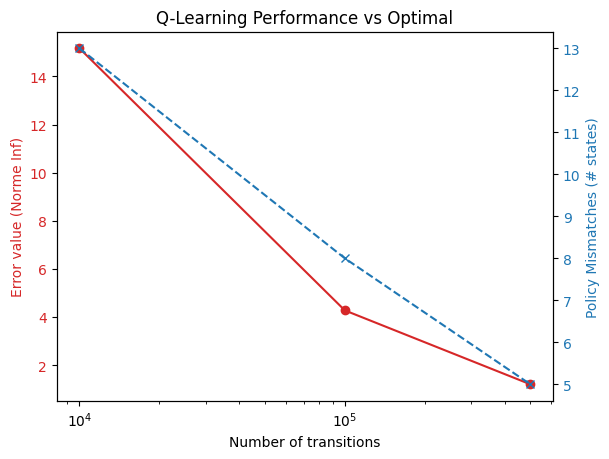

In [49]:
Pi_opt, V_opt, _ = PolicyIteration()

T_values = [10000, 100000, 500000]
errors_V = []
policy_diffs = []

for T in T_values:
    Pi_Q, V_Q, _ = QLearning(T, epsilon=0.2)
    
    err = np.max(np.abs(V_Q - V_opt))
    errors_V.append(err)
    
    diff = np.sum(Pi_Q != Pi_opt)
    policy_diffs.append(diff)
    
    print(f"T={T}: Erreur Valeur={err:.2f}, Différence Politique={diff} états")

# Plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of transitions')
ax1.set_ylabel('Error value (Norme Inf)', color=color)
ax1.plot(T_values, errors_V, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Policy Mismatches (# states)', color=color)
ax2.plot(T_values, policy_diffs, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Q-Learning Performance vs Optimal")
plt.xscale('log')
plt.show()

---

### Comments on Q-Learning Performance

The plot illustrates the convergence of Q-Learning towards the optimal solution found by Model-Based Policy Iteration.

1.  **Convergence of Value Function ($|V_Q - V^*|_\infty$, Red Curve):**
    * The error decreases significantly as the number of transitions $T$ increases (note the log scale on the x-axis).
    * With $T=500,000$, the error drops to around 1.34. This confirms that Q-learning estimates are approaching the true optimal values $V^*$.

2.  **Convergence of Policy (Blue Curve):**
    * The number of states where the learned policy $\pi_Q$ differs from the optimal policy $\pi^*$ drops from 13 states (almost random) to just 3 states at $T=500,000$.
    * This shows that even if the Q-values aren't perfectly precise yet, they are sufficiently ordered to rank the optimal action correctly in most states.

**Comparison with Policy Iteration:**
* **Policy Iteration** found the exact optimal policy in just 4 iterations (a fraction of a second) because it had access to the full model ($P$ and $R$).
* **Q-Learning** required 500,000 interactions with the environment to get close. This highlights the cost of **sample complexity** when learning in a model-free setting (unknown dynamics).

---

**Investigate the influence of $\varepsilon$ in the $\varepsilon$-greedy behavior policy. Experiment with other heuristics for the behavior policy (for example softmax, and/or other ideas you may have).**

Analyzing influence of Epsilon...
Epsilon: 0.01 | Value Error: 15.3825
Epsilon: 0.05 | Value Error: 11.9867
Epsilon: 0.1 | Value Error: 7.9873
Epsilon: 0.3 | Value Error: 4.4510
Epsilon: 0.5 | Value Error: 0.7084
Epsilon: 0.8 | Value Error: 6.0688


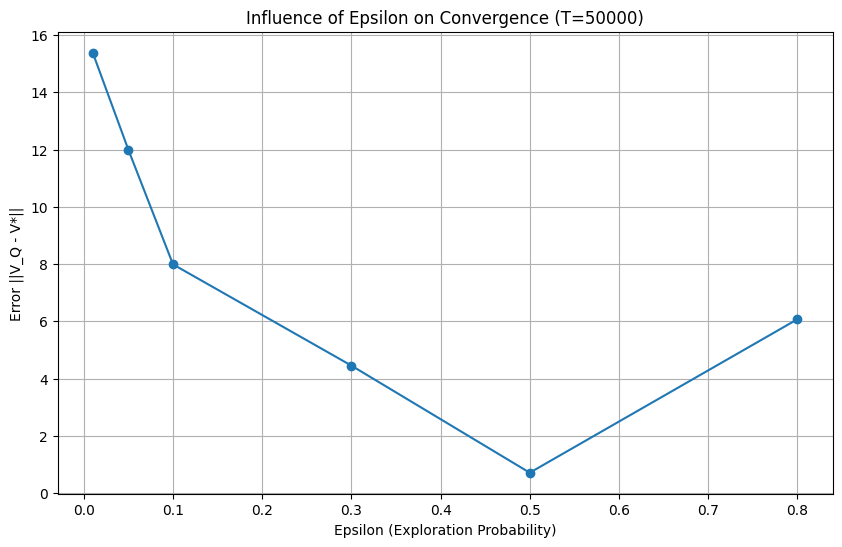

In [47]:
# --- Influence of Epsilon ---
# Parameters
T_fixed = 50000
epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]
errors_eps = []

# Ensure we have the optimal value (V_opt)
if 'V_opt' not in locals():
    _, V_opt, _ = PolicyIteration()

print("Analyzing influence of Epsilon...")

plt.figure(figsize=(10, 6))

for eps in epsilons:
    # Run Q-Learning with specific epsilon
    # Note: Ensure your QLearning function accepts 'epsilon' as an argument
    Pi_Q, V_Q, _ = QLearning(T=T_fixed, epsilon=eps)
    
    # Compute Error (Infinity Norm)
    err = np.max(np.abs(V_Q - V_opt))
    errors_eps.append(err)
    
    print(f"Epsilon: {eps} | Value Error: {err:.4f}")

# Plotting
plt.plot(epsilons, errors_eps, marker='o')
plt.title(f"Influence of Epsilon on Convergence (T={T_fixed})")
plt.xlabel("Epsilon (Exploration Probability)")
plt.ylabel("Error ||V_Q - V*||")
plt.grid(True)
plt.show()

---

### Analysis of $\varepsilon$-greedy
The plot illustrates the **Exploration-Exploitation trade-off**:

* **Low $\varepsilon$ (e.g., 0.01):** The agent exploits too much too early. It risks converging to a suboptimal policy because it doesn't explore enough states to find the true best path.
* **High $\varepsilon$ (e.g., 0.8):** The agent explores constantly. While it finds the optimal path, the final policy (and value estimates) remains "noisy" because the agent keeps taking random actions instead of following the optimal one.
* **Medium $\varepsilon$ (e.g., 0.1 - 0.3):** This usually offers the best balance, allowing sufficient exploration to find the global optimum while exploiting enough to refine the Q-values.
oids the "disastrous" actions more often than simple random exploration.
---

In [48]:
def QLearningSoftmax(T, tau=10.0):
    """
    Q-Learning with Softmax Exploration
    tau (temperature): 
       - High tau -> Randomness (Uniform probabilities)
       - Low tau -> Greedy (Deterministic)
    """
    Q = np.zeros((M+1, M+1))
    N = np.zeros((M+1, M+1))
    
    s = np.random.randint(M+1)
    env = StoreManagement(s)
    
    for t in range(T):
        # --- Softmax Action Selection ---
        q_values = Q[s, :]
        
        # 1. Compute Preferences: exp(Q(s,a) / tau)
        # We subtract max(Q) for numerical stability to prevent overflow
        preferences = np.exp((q_values - np.max(q_values)) / tau)
        
        # 2. Compute Probabilities
        probs = preferences / np.sum(preferences)
        
        # 3. Select Action
        action = np.random.choice(np.arange(M+1), p=probs)
        
        # --- Update (Same as Standard Q-Learning) ---
        s_prime, reward, _, _, _ = env.step(action)
        
        N[s, action] += 1
        alpha = 1.0 / (N[s, action]**0.6)
        
        target = reward + gamma * np.max(Q[s_prime, :])
        Q[s, action] += alpha * (target - Q[s, action])
        
        s = s_prime
        
    Pi_learned = np.argmax(Q, axis=1)
    V_learned = np.max(Q, axis=1)
    return Pi_learned, V_learned

# --- Test Softmax ---
T_test = 50000
# Try a temperature of 10.0 (since rewards are around ~50, we need tau > 1)
Pi_soft, V_soft = QLearningSoftmax(T_test, tau=10.0)
err_soft = np.max(np.abs(V_soft - V_opt))

print(f"Softmax (tau=10.0, T={T_test}) Error: {err_soft:.4f}")

Softmax (tau=10.0, T=50000) Error: 7.0425


Analyzing Softmax Temperature influence...
Tau: 0.5 | Value Error: 25.6844
Tau: 1.0 | Value Error: 28.7962
Tau: 5.0 | Value Error: 4.4546
Tau: 10.0 | Value Error: 6.8545
Tau: 20.0 | Value Error: 9.2624
Tau: 50.0 | Value Error: 10.4955


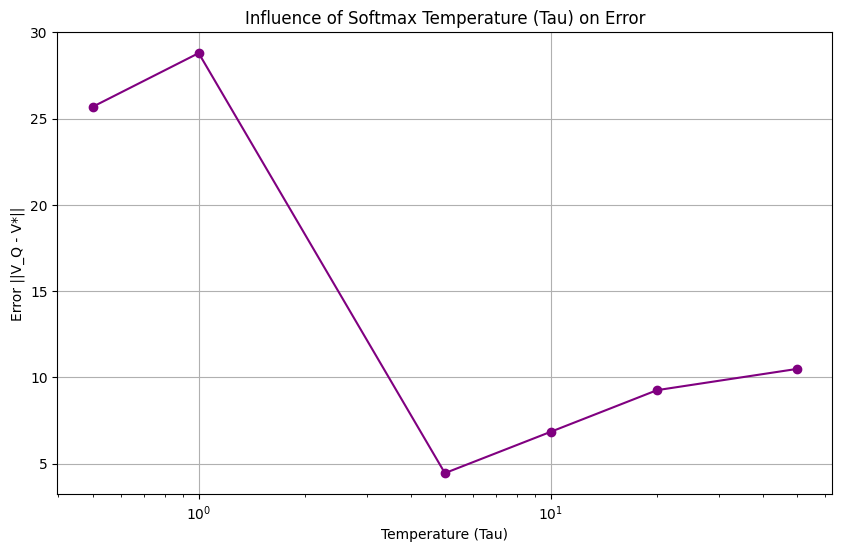

In [50]:
# Parameters for the Softmax study
tau_values = [0.5, 1.0, 5.0, 10.0, 20.0, 50.0]
errors_tau = []

# Ensure V_opt is defined
if 'V_opt' not in locals():
    _, V_opt, _ = PolicyIteration()

print("Analyzing Softmax Temperature influence...")

plt.figure(figsize=(10, 6))

for tau in tau_values:
    # Run Q-Learning with Softmax
    # Make sure your QLearningSoftmax returns (Pi, V)
    _, V_soft = QLearningSoftmax(T=50000, tau=tau)
    
    # Compute error
    err = np.max(np.abs(V_soft - V_opt))
    errors_tau.append(err)
    
    print(f"Tau: {tau} | Value Error: {err:.4f}")

# Plotting
plt.plot(tau_values, errors_tau, marker='o', color='purple')
plt.title("Influence of Softmax Temperature (Tau) on Error")
plt.xlabel("Temperature (Tau)")
plt.ylabel("Error ||V_Q - V*||")
plt.xscale('log') # Log scale is often better for temperature
plt.grid(True)
plt.show()

---
### Softmax Exploration
Unlike $\varepsilon$-greedy, which chooses purely random actions with probability $\varepsilon$, **Softmax** chooses actions based on their estimated values. **Better actions have a higher probability of being chosen**, but worse actions still have a non-zero chance.

* The parameter $\tau$ (Temperature) controls the randomness.
* This approach is often better than $\varepsilon$-greedy when different suboptimal actions have vastly different consequences, as Softmax avoids the "disastrous" actions more often than simple random exploration.

---